# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022  
  
This is a code supporting the corresponding paper.

Packages import:

In [1]:
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import pandas as pd

import albumentations as A

import SimpleITK as sitk

plt.style.use("ggplot")

Using TensorFlow backend.
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


GPU assignment:

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

W1115 12:30:32.656324 56852 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1115 12:30:32.656324 56852 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1115 12:30:32.671953 56852 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1115 12:30:35.046437 56852 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import nibabel as nib
import pickle

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

In [5]:
import math

In [6]:
from keras.losses import binary_crossentropy

## 1. Data load

In [7]:
sub_names_train = ['AMC008', 'AMC003', 'AMC011', 'AMC010', 'AMC014', 'AMC013', 'AMC002', 'AMC001', 'AMC018',  
                   'MUMC084', 'MUMC072', 'MUMC002', 'MUMC030', 'MUMC065', 'MUMC010', 'MUMC031', 'MUMC037', 'MUMC111', 
                   'MUMC009', 'MUMC013', 'MUMC033', 'MUMC056', 'MUMC082', 'MUMC035', 'MUMC119', 'MUMC040', 'MUMC118', 
                   'MUMC089', 'MUMC060', 'MUMC074', 'MUMC011', 'MUMC048', 'MUMC120', 'MUMC077', 'MUMC044', 'MUMC068', 
                   'MUMC001', 'MUMC125', 'MUMC105', 'MUMC055', 'MUMC098', 'MUMC073', 'MUMC026', 'MUMC099', 'MUMC101', 
                   'MUMC075', 'MUMC100', 'MUMC076', 'MUMC121', 'MUMC050', 'MUMC061', 'MUMC092', 'MUMC017', 'MUMC109', 
                   'MUMC091', 'MUMC129', 'MUMC016', 'MUMC067', 'MUMC045', 'MUMC096', 'MUMC028', 'MUMC020', 'MUMC095', 
                   'MUMC003', 'MUMC117', 'MUMC106', 'MUMC122', 'MUMC019', 'MUMC085', 'MUMC046', 'MUMC116', 'MUMC057', 
                   'MUMC090', 'MUMC110', 'MUMC024', 'MUMC015', 'MUMC032', 'MUMC039', 'MUMC049', 'MUMC063', 'MUMC021', 
                   'MUMC029', 'MUMC023', 'MUMC104', 'MUMC066', 'MUMC058', 'MUMC128', 'MUMC053', 'MUMC108', 
                   'UMCU016', 'UMCU039', 'UMCU001', 'UMCU027', 'UMCU020', 'UMCU009', 'UMCU030', 'UMCU024', 'UMCU002', 
                   'UMCU022', 'UMCU035', 'UMCU033', 'UMCU038', 'UMCU037', 'UMCU032', 'UMCU031', 'UMCU026']
sub_names_valid = ['AMC005', 'AMC007', 
                   'MUMC123', 'MUMC025', 'MUMC041', 'MUMC124', 'MUMC113', 'MUMC081', 'MUMC103', 'MUMC006', 'MUMC112', 
                   'MUMC051', 'MUMC008', 'MUMC126', 'MUMC088', 'MUMC097', 'MUMC047', 'MUMC014', 'MUMC078', 
                   'UMCU010', 'UMCU023', 'UMCU017', 'UMCU012']
sub_names_test = ['AMC012', 'AMC006', 
                  'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038', 'MUMC093', 'MUMC107', 
                  'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 'MUMC059', 'MUMC080', 
                  'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [8]:
dirname_imgdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTr/'
dirname_imgdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTs1/'
dirname_gtdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTr/'
dirname_gtdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTs1/'
dirname_nnunetdata = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Tr/'
dirname_nnunetdata_test = 'D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Ts1/'

In [9]:
n_samples_train = 0

for sub_name in sub_names_train:
    
    filename_img = dirname_imgdata + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata + sub_name + '.pkl'
    filename_gt = dirname_gtdata + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_train += img.shape[0]
    
n_samples_train

1539

In [10]:
n_samples_valid = 0

for sub_name in sub_names_valid:
    
    filename_img = dirname_imgdata + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata + sub_name + '.pkl'
    filename_gt = dirname_gtdata + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_valid += img.shape[0]
    
n_samples_valid

339

In [11]:
n_samples_test = 0

for sub_name in sub_names_test:
    
    filename_img = dirname_imgdata_test + sub_name + '_0000.nii.gz'
    filename_sm = dirname_nnunetdata_test + sub_name + '.npz'
    filename_pkl = dirname_nnunetdata_test + sub_name + '.pkl'
    filename_gt = dirname_gtdata_test + sub_name + '.nii.gz'
    
    img = nib.load(filename_img).get_fdata().T
    n_samples_test += img.shape[0]
    
n_samples_test

350

In [12]:
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_SIDE = 64
IMG_SIDE_LARGE = 128

In [13]:
def generate_crop(gt_xmin, gt_xmax, gt_ymin, gt_ymax, im_side=IMG_SIDE, rs=0):
    
    random.seed(rs)
        
    side_x = gt_xmax - gt_xmin
    side_y = gt_ymax - gt_ymin
    
    crop_xmin = max(0, gt_xmin-random.randint(2, max(2, im_side-side_x)))
    crop_ymin = max(0, gt_ymin-random.randint(2, max(2, im_side-side_y)))
    
    crop_xmax = crop_xmin + im_side
    crop_ymax = crop_ymin + im_side
    
    if crop_xmax>IMG_HEIGHT-1:
        crop_xmax=IMG_HEIGHT
        crop_xmin=crop_xmax-im_side
        
    if crop_ymax>IMG_WIDTH-1:
        crop_ymax=IMG_WIDTH
        crop_ymin=crop_ymax-im_side

    crop = [crop_xmin, crop_xmax, crop_ymin, crop_ymax]
    
    return crop

In [14]:
#def generate_crop(gt_xmin, gt_xmax, gt_ymin, gt_ymax, im_side=IMG_SIDE, rs=0):
    
#    random.seed(rs)
        
#    side_x = gt_xmax - gt_xmin
#    side_y = gt_ymax - gt_ymin
    
#    crop_xmin = max(0, gt_xmin-random.randint(64-side_x, 64))
#    crop_ymin = max(0, gt_ymin-random.randint(64-side_y, 64))
    
#    crop_xmax = crop_xmin + im_side
#    crop_ymax = crop_ymin + im_side
    
#    if crop_xmax>IMG_HEIGHT-1:
#        crop_xmax=IMG_HEIGHT
#        crop_xmin=crop_xmax-im_side
        
#    if crop_ymax>IMG_WIDTH-1:
#        crop_ymax=IMG_WIDTH
#        crop_ymin=crop_ymax-im_side

#    crop = [crop_xmin, crop_xmax, crop_ymin, crop_ymax]
    
#    return crop

In [15]:
def norm_crop(img_arr, gt_arr, counter, n_crops = 5):

    img_min = np.min(img_arr) 
    img_max = np.max(img_arr) 
    
    img_norm = np.copy((img_arr - img_min)/(img_max - img_min)*255).astype(np.uint8)

    gt_xmin = np.min(np.where(gt_arr > 0)[0])
    gt_xmax = np.max(np.where(gt_arr > 0)[0])
    gt_ymin = np.min(np.where(gt_arr > 0)[1])
    gt_ymax = np.max(np.where(gt_arr > 0)[1])
    
    crops = []
    
    for i in range(0, n_crops):
        crop = generate_crop(gt_xmin, gt_xmax, gt_ymin, gt_ymax, im_side=IMG_SIDE, rs=counter)
        crops.append(crop)
        counter += 1
        
    return img_norm, crops, counter
    

In [16]:
def fill_arrays(X, y, sub_names, dirname_img, dirname_nnunet, dirname_gt, n_crops = 5):
    
    i = 0
    counter = 0

    for sub_name in sub_names:
       

        filename_img = dirname_img + sub_name + '_0000.nii.gz'
        filename_sm = dirname_nnunet + sub_name + '.npz'
        filename_pkl = dirname_nnunet + sub_name + '.pkl'
        filename_gt = dirname_gt + sub_name + '.nii.gz'

        img = nib.load(filename_img).get_fdata().T
        gt = nib.load(filename_gt).get_fdata().T
        sm_cropped = np.load(filename_sm)['softmax']
        with open(filename_pkl, 'rb') as f:
            p = pickle.load(f)
        crop_box = p['crop_bbox']
        sm = np.zeros(img.shape, dtype=np.float16)
        sm[crop_box[0][0]:crop_box[0][1],crop_box[1][0]:crop_box[1][1],crop_box[2][0]:crop_box[2][1]]=sm_cropped[1, ...]

        for j in range (0, img.shape[0]):
            img_norm, crops, counter = norm_crop(img[j, ...], gt[j, ...], counter, n_crops)
            for crop in crops:
                img_norm_crop = np.copy(img_norm[crop[0]:crop[1], crop[2]:crop[3]])
                gt_crop = np.copy(gt[j, crop[0]:crop[1], crop[2]:crop[3]])
                sm_crop = np.copy(255*sm[j, crop[0]:crop[1], crop[2]:crop[3]])
                X[i, ..., 0] = img_norm_crop
                X[i, ..., 1] = sm_crop
                y[i, ..., 0] = gt_crop
                i += 1
                
                
    return None
    

In [17]:
X_train = np.zeros((n_samples_train*5, IMG_SIDE, IMG_SIDE, 2), dtype = np.uint8)
y_train = np.zeros((n_samples_train*5, IMG_SIDE, IMG_SIDE, 1), dtype = np.uint8)

X_valid = np.zeros((n_samples_valid*5, IMG_SIDE, IMG_SIDE, 2), dtype = np.uint8)
y_valid = np.zeros((n_samples_valid*5, IMG_SIDE, IMG_SIDE, 1), dtype = np.uint8)

#X_test = np.zeros((n_samples_test, IMG_SIDE, IMG_SIDE, 2), dtype = np.uint8)
#y_test = np.zeros((n_samples_test, IMG_SIDE, IMG_SIDE, 1), dtype = np.uint8)

In [18]:
fill_arrays(X_train, y_train, sub_names_train, dirname_imgdata, dirname_nnunetdata, dirname_gtdata)
fill_arrays(X_valid, y_valid, sub_names_valid, dirname_imgdata, dirname_nnunetdata, dirname_gtdata)

In [19]:
from skimage.measure import  regionprops

In [29]:
area_max = 0
side_max = 0

for i in range (0, y_train.shape[0]):
    slice_array = y_train[i, ..., 0]
    regions = regionprops((slice_array>0).astype(np.uint8))
    for props in regions:
        if props.axis_major_length>side_max:
            side_max = props.axis_major_length
        if props.area>area_max:
            area_max = props.area
        
print (area_max, side_max)

2509 84.87693942544927


In [31]:
(2509)**(0.5)

50.08991914547278

In [17]:
#fill_arrays(X_test, y_test, sub_names_test, dirname_imgdata_test, dirname_nnunetdata_test, dirname_gtdata_test, n_crops=1)

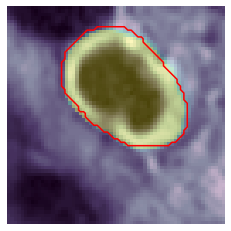

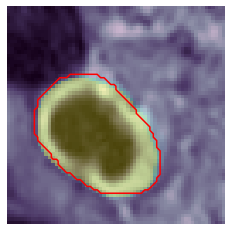

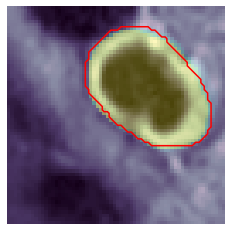

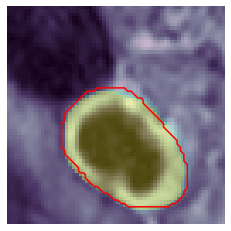

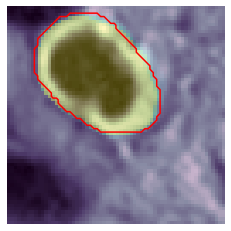

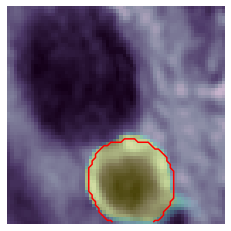

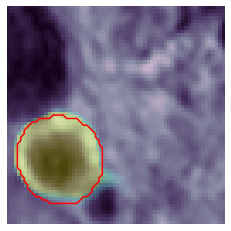

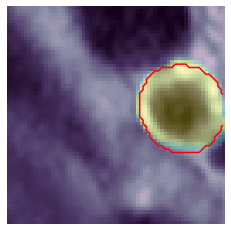

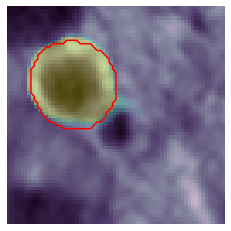

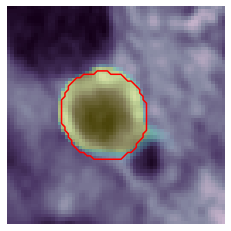

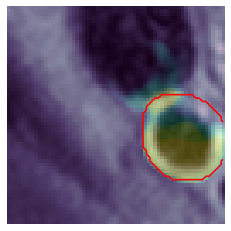

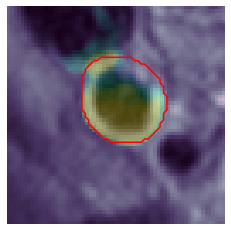

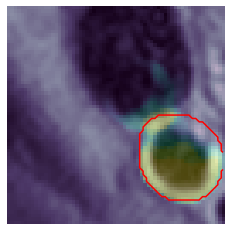

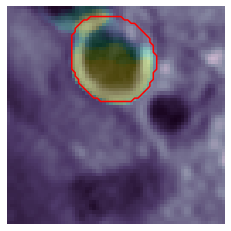

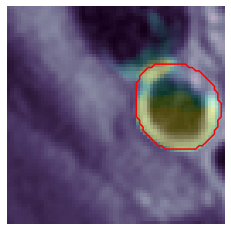

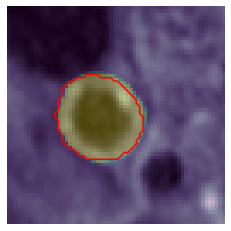

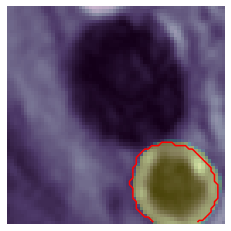

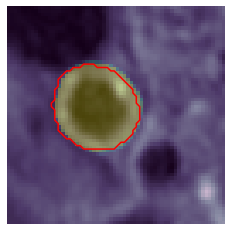

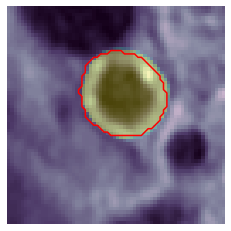

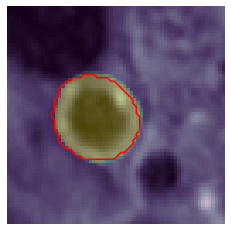

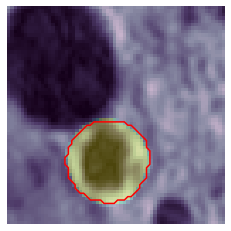

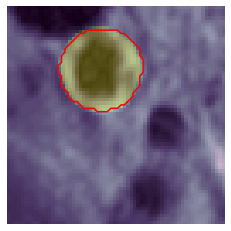

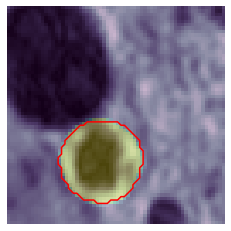

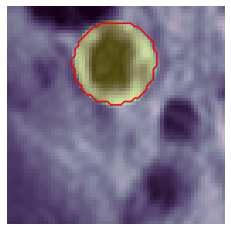

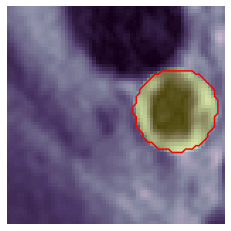

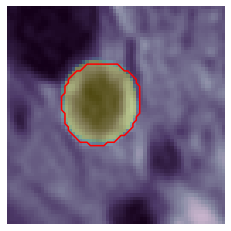

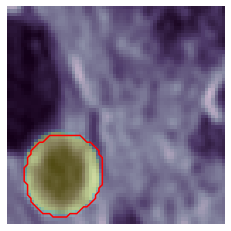

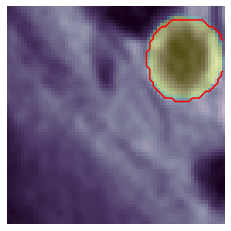

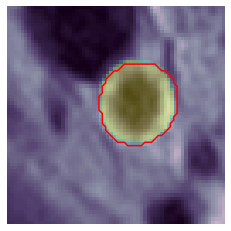

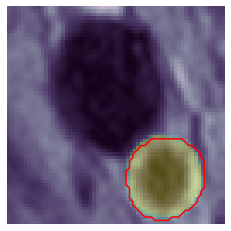

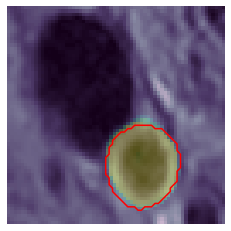

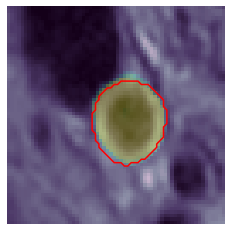

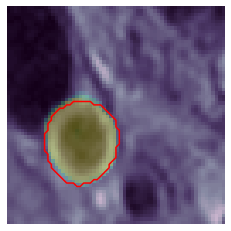

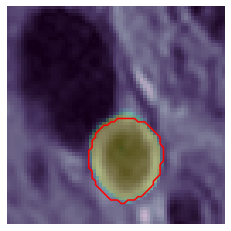

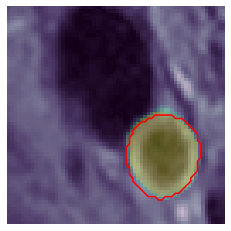

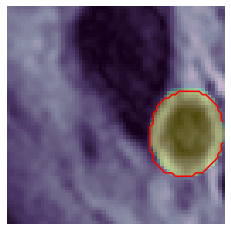

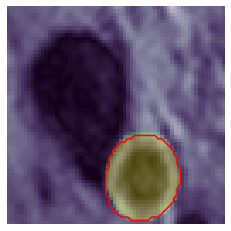

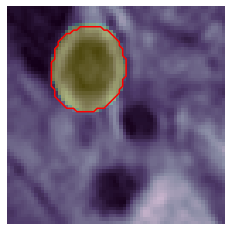

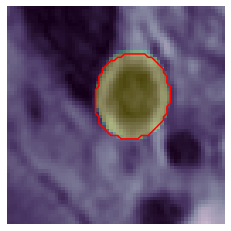

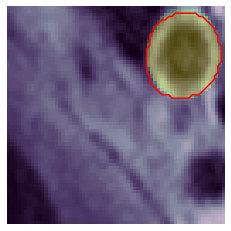

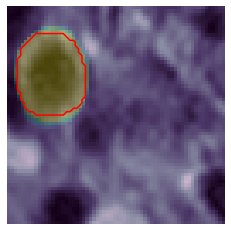

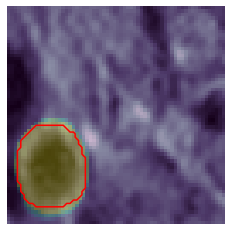

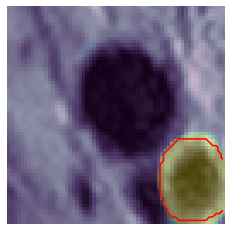

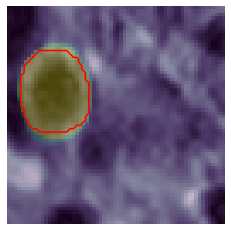

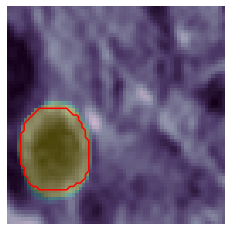

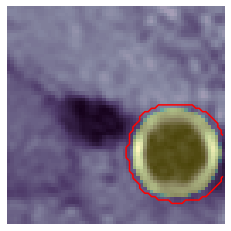

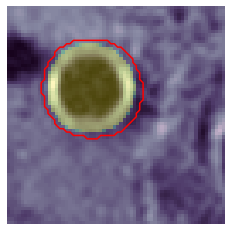

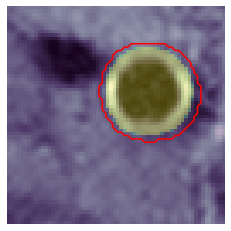

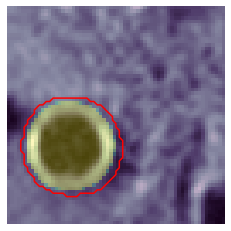

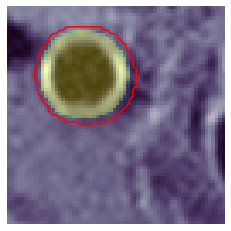

In [18]:
# visualization of the training patches

for i in range (100, 150):
    plt.imshow(X_train[i, ..., 0], cmap = 'bone')
    plt.imshow(X_train[i, ..., 1], alpha = 0.3)
    plt.contour(y_train[i, ..., 0], colors='r', levels=[0.5])
    plt.axis('Off')
    plt.show()

In [19]:
#for i in range (145, 155):
#    plt.imshow(X_test[i, ..., 0], cmap = 'bone')
#    plt.imshow(X_test[i, ..., 1], alpha = 0.3)
#    plt.contour(y_test[i, ..., 0], colors='r', levels=[0.5])
#    plt.axis('Off')
#    plt.show()

## 2. Data augmentation

Defining transformations:

In [20]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(min_max_height=(48, 64), height=64, width=64, p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.RandomGamma(p=0.5)
])

Generation of the augmented patches:

In [21]:
# n_augms random transformations of the images X and masks y

def augment_ds(X, y, n_augms):
    
    counter = 0
    dim = y[0, ..., 0].shape
    n_samples = y.shape[0]
    
    X_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 2), dtype = np.uint8)
    y_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    
    for smpl in range (0, n_samples):
        for augm in range (0, n_augms):

            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=y[smpl, ..., 0])
            X_aug[counter, ..., 0] = augmented['image']
            y_aug[counter, ..., 0] = augmented['mask']
            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=X[smpl, ..., 1])
            X_aug[counter, ..., 1] = augmented['mask']
            counter += 1
            
    return X_aug, y_aug    

Writing augmented data into arrays:

In [22]:
X_train_aug, y_train_aug = augment_ds(X_train, y_train, 10)
X_valid_aug, y_valid_aug = augment_ds(X_valid, y_valid, 10)

Visualization of the transformed images:

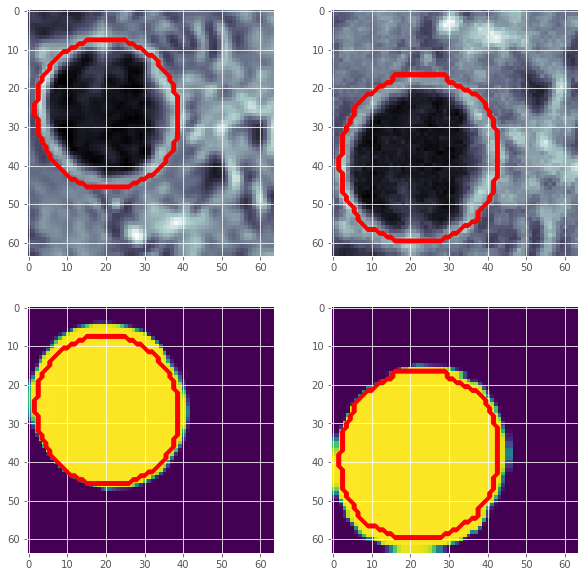

In [30]:
n_sample = 150

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(X_train[n_sample//10, ..., 0], cmap = 'bone')
plt.contour(y_train[n_sample//10, ..., 0], colors='r')
plt.subplot(222)
plt.imshow(X_train_aug[n_sample, ..., 0], cmap = 'bone')
plt.contour(y_train_aug[n_sample, ..., 0], colors='r')
plt.subplot(223)
plt.imshow(X_train[n_sample//10, ..., 1], vmin=0, vmax=255)
plt.contour(y_train[n_sample//10, ..., 0], colors='r')
plt.subplot(224)
plt.imshow(X_train_aug[n_sample, ..., 1], vmin=0, vmax=255)
plt.contour(y_train_aug[n_sample, ..., 0], colors='r')
plt.show()

## 3. U-Net construction

Defining blocks:

In [23]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('elu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Custom scores:

In [24]:
def dice_coef(y_true, y_pred):
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def lf(x, scaling = 1):
    return (1-K.exp(-scaling*x))/(1+K.exp(-scaling*x))

def custom_loss(y_true, y_pred):
    
    return 0.5*lf(keras.losses.binary_crossentropy(y_true,y_pred))+0.5*dice_loss(y_true,y_pred)

In [25]:
input_img = Input((IMG_SIDE, IMG_SIDE, 2), name='img')

W1115 12:35:19.481569 56852 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [26]:
class TestLoss_4(object):
    def __init__(self):
        self.var_1 = None
        self.var_2 = None
        self.var_3 = None
        self.var_4 = None
        self.var_epoch = None
        
    def __call__(self, y_true, y_pred):
        if self.var_1 is None:
            self.var_1 = K.variable(np.zeros((64, 64, 64, 1)))
        if self.var_2 is None:
            self.var_2 = K.variable(np.zeros((64, 64, 64, 1)))
        if self.var_3 is None:
            self.var_3 = K.variable(np.zeros((64, 64, 64, 1)))
        if self.var_4 is None:
            self.var_4 = K.variable(np.zeros((64, 64, 64, 1)))
        if self.var_epoch is None:
            self.var_epoch = K.variable(0)
        
        y_mean = (self.var_1+self.var_2+self.var_3+self.var_4+y_pred)/5
        y_std = ((self.var_1-y_mean)**2+(self.var_2-y_mean)**2+(self.var_3-y_mean)**2+(self.var_4-y_mean)**2+(y_pred-y_mean)**2)/5
        uncertainty_loss = lf(K.sum(y_std))
        l = custom_loss(y_true, y_mean)+uncertainty_loss
        
        K.update(self.var_4, self.var_3)
        K.update(self.var_3, self.var_2)
        K.update(self.var_2, self.var_1)
        K.update(self.var_1, y_pred)
       
        return l

In [44]:
model_aug_ul_4 = get_unet(input_img, n_filters=16, dropout=0.10, batchnorm=True)
model_aug_ul_4.compile(optimizer=Adam(lr=0.000000001), 
                   loss=TestLoss_4(), 
                   metrics=[dice_coef])
model_aug_ul_4.summary()
model_aug_ul_4.load_weights('../res/plaq-u-net_aug_dce_2.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 64, 64, 16)   304         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 64, 64, 16)   64          conv2d_116[0][0]                 
__________________________________________________________________________________________________
activation_110 (Activation)     (None, 64, 64, 16)   0           batch_normalization_110[0][0]    
__________________________________________________________________________________________________
max_poolin

In [45]:
callbacks_simple_ul_4 = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000000000001, verbose=1),
    ModelCheckpoint('../res/plaq-uncertainty-net_simple.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

callbacks_aug_ul_4 = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000000000000001, verbose=1),
    ModelCheckpoint('../res/plaq-uncertainty-net_aug.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [40]:
results_simple_ul_4 = model_aug_ul_4.fit(X_train[:7680, ...], y_train[:7680, ...],
                                  batch_size=64, epochs=100, 
                                  callbacks=callbacks_simple_ul_4, 
                                  validation_data=(X_valid[:1664, ...], y_valid[:1664, ...]))

Train on 7680 samples, validate on 1664 samples
Epoch 1/100
7680/7680 [==============================] - 14s 2ms/step - loss: 1.4136 - dice_coef: 0.9434 - val_loss: 1.4213 - val_dice_coef: 0.9138

Epoch 00001: val_loss improved from inf to 1.42132, saving model to ../res/plaq-u-net_simple_ul_4.h5
Epoch 2/100
7680/7680 [==============================] - 7s 847us/step - loss: 1.4135 - dice_coef: 0.9434 - val_loss: 1.4213 - val_dice_coef: 0.9136

Epoch 00002: val_loss improved from 1.42132 to 1.42130, saving model to ../res/plaq-u-net_simple_ul_4.h5
Epoch 3/100
7680/7680 [==============================] - 6s 840us/step - loss: 1.4135 - dice_coef: 0.9433 - val_loss: 1.4213 - val_dice_coef: 0.9134

Epoch 00003: val_loss improved from 1.42130 to 1.42127, saving model to ../res/plaq-u-net_simple_ul_4.h5
Epoch 4/100
7680/7680 [==============================] - 6s 802us/step - loss: 1.4135 - dice_coef: 0.9431 - val_loss: 1.4212 - val_dice_coef: 0.9131

Epoch 00004: ReduceLROnPlateau reducing le

KeyboardInterrupt: 

In [46]:
results_aug_ul_4 = model_aug_ul_4.fit(X_train_aug[:76928, ...], y_train_aug[:76928, ...],
                                  batch_size=64, epochs=100, 
                                  callbacks=callbacks_aug_ul_4, 
                                  validation_data=(X_valid_aug[:16896, ...], y_valid_aug[:16896, ...]))

Train on 76928 samples, validate on 16896 samples
Epoch 1/100
76928/76928 [==============================] - 79s 1ms/step - loss: 1.4227 - dice_coef: 0.9457 - val_loss: 1.4322 - val_dice_coef: 0.9104

Epoch 00001: val_loss improved from inf to 1.43215, saving model to ../res/plaq-u-net_aug_ul_4.h5
Epoch 2/100
76928/76928 [==============================] - 60s 777us/step - loss: 1.4227 - dice_coef: 0.9457 - val_loss: 1.4321 - val_dice_coef: 0.9103

Epoch 00002: val_loss improved from 1.43215 to 1.43211, saving model to ../res/plaq-u-net_aug_ul_4.h5
Epoch 3/100
76928/76928 [==============================] - 69s 892us/step - loss: 1.4226 - dice_coef: 0.9457 - val_loss: 1.4320 - val_dice_coef: 0.9102

Epoch 00003: val_loss improved from 1.43211 to 1.43200, saving model to ../res/plaq-u-net_aug_ul_4.h5
Epoch 4/100
76928/76928 [==============================] - 63s 815us/step - loss: 1.4225 - dice_coef: 0.9457 - val_loss: 1.4320 - val_dice_coef: 0.9099

Epoch 00004: val_loss improved from 1.

76928/76928 [==============================] - 658s 9ms/step - loss: 1.4222 - dice_coef: 0.9457 - val_loss: 1.4318 - val_dice_coef: 0.9090

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1e-15.

Epoch 00070: val_loss did not improve from 1.43173
Epoch 71/100
76928/76928 [==============================] - 659s 9ms/step - loss: 1.4223 - dice_coef: 0.9456 - val_loss: 1.4318 - val_dice_coef: 0.9089

Epoch 00071: val_loss did not improve from 1.43173
Epoch 72/100
76928/76928 [==============================] - 658s 9ms/step - loss: 1.4222 - dice_coef: 0.9457 - val_loss: 1.4318 - val_dice_coef: 0.9090

Epoch 00072: val_loss did not improve from 1.43173
Epoch 73/100
76928/76928 [==============================] - 661s 9ms/step - loss: 1.4222 - dice_coef: 0.9457 - val_loss: 1.4318 - val_dice_coef: 0.9090

Epoch 00073: ReduceLROnPlateau reducing learning rate to 1e-15.

Epoch 00073: val_loss did not improve from 1.43173
Epoch 74/100
76928/76928 [==============================] - 659s 9m

In [46]:
input_img = Input((IMG_SIDE, IMG_SIDE, 2), name='img')

model_simple = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_simple.compile(optimizer=Adam(), loss=dice_loss, metrics=[dice_coef])
model_simple.summary()

model_aug = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_aug.compile(optimizer=Adam(), loss=dice_loss, metrics=[dice_coef])
model_aug.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 64, 64, 16)   304         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 64, 64, 16)   64          conv2d_192[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 64, 64, 16)   0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 64, 64, 16)   304         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_200 (BatchN (None, 64, 64, 16)   64          conv2d_211[0][0]                 
__________________________________________________________________________________________________
activation_200 (Activation)     (None, 64, 64, 16)   0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
max_poolin

Callbacks:

In [47]:
callbacks_simple = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/plaq-u-net_simple.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

callbacks_aug = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/plaq-u-net_aug.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [48]:
# simple model (w/o data augmentation)

results_simple = model_simple.fit(X_train, y_train,
                                  batch_size=64, epochs=100, 
                                  callbacks=callbacks_simple, 
                                  validation_data=(X_valid, y_valid))

Train on 7695 samples, validate on 1695 samples
Epoch 1/100
7695/7695 [==============================] - 19s 3ms/step - loss: 0.3671 - acc: 0.9169 - dice_coef: 0.6329 - val_loss: 0.2405 - val_acc: 0.9446 - val_dice_coef: 0.7595

Epoch 00001: val_loss improved from inf to 0.24046, saving model to ../res/plaq-u-net_simple_dce_2.h5
Epoch 2/100
7695/7695 [==============================] - 7s 954us/step - loss: 0.2436 - acc: 0.9603 - dice_coef: 0.7564 - val_loss: 0.2101 - val_acc: 0.9520 - val_dice_coef: 0.7899

Epoch 00002: val_loss improved from 0.24046 to 0.21013, saving model to ../res/plaq-u-net_simple_dce_2.h5
Epoch 3/100
7695/7695 [==============================] - 7s 938us/step - loss: 0.2144 - acc: 0.9649 - dice_coef: 0.7856 - val_loss: 0.1971 - val_acc: 0.9550 - val_dice_coef: 0.8029

Epoch 00003: val_loss improved from 0.21013 to 0.19713, saving model to ../res/plaq-u-net_simple_dce_2.h5
Epoch 4/100
7695/7695 [==============================] - 7s 960us/step - loss: 0.1933 - acc: 

7695/7695 [==============================] - 7s 955us/step - loss: 0.0600 - acc: 0.9791 - dice_coef: 0.9400 - val_loss: 0.0931 - val_acc: 0.9642 - val_dice_coef: 0.9069

Epoch 00030: val_loss improved from 0.09470 to 0.09312, saving model to ../res/plaq-u-net_simple_dce_2.h5
Epoch 31/100
7695/7695 [==============================] - 7s 940us/step - loss: 0.0597 - acc: 0.9792 - dice_coef: 0.9403 - val_loss: 0.0931 - val_acc: 0.9642 - val_dice_coef: 0.9069

Epoch 00031: val_loss did not improve from 0.09312
Epoch 32/100
7695/7695 [==============================] - 7s 920us/step - loss: 0.0596 - acc: 0.9793 - dice_coef: 0.9404 - val_loss: 0.0931 - val_acc: 0.9642 - val_dice_coef: 0.9069

Epoch 00032: val_loss did not improve from 0.09312
Epoch 33/100
7695/7695 [==============================] - 7s 949us/step - loss: 0.0594 - acc: 0.9793 - dice_coef: 0.9406 - val_loss: 0.0928 - val_acc: 0.9643 - val_dice_coef: 0.9072

Epoch 00033: val_loss improved from 0.09312 to 0.09284, saving model to .

KeyboardInterrupt: 

In [49]:
# data augmentation

results_aug = model_aug.fit(X_train_aug, y_train_aug,
                            batch_size=64, epochs=100, 
                            callbacks=callbacks_aug, 
                            validation_data=(X_valid_aug, y_valid_aug))

Train on 76950 samples, validate on 16950 samples
Epoch 1/200
76950/76950 [==============================] - 84s 1ms/step - loss: 0.1211 - acc: 0.9642 - dice_coef: 0.8789 - val_loss: 0.1202 - val_acc: 0.9604 - val_dice_coef: 0.8798

Epoch 00001: val_loss improved from inf to 0.12017, saving model to ../res/plaq-u-net_aug_dce_2.h5
Epoch 2/200
76950/76950 [==============================] - 74s 967us/step - loss: 0.0707 - acc: 0.9731 - dice_coef: 0.9293 - val_loss: 0.1065 - val_acc: 0.9615 - val_dice_coef: 0.8935

Epoch 00002: val_loss improved from 0.12017 to 0.10647, saving model to ../res/plaq-u-net_aug_dce_2.h5
Epoch 3/200
76950/76950 [==============================] - 74s 957us/step - loss: 0.0620 - acc: 0.9737 - dice_coef: 0.9380 - val_loss: 0.0973 - val_acc: 0.9621 - val_dice_coef: 0.9027

Epoch 00003: val_loss improved from 0.10647 to 0.09728, saving model to ../res/plaq-u-net_aug_dce_2.h5
Epoch 4/200
76950/76950 [==============================] - 73s 953us/step - loss: 0.0586 - a

KeyboardInterrupt: 